In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Dự đoán giá vàng

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_gold = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/gold_price_2018_2024.csv')
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
# df1=df.reset_index()['Close']

In [ ]:
df_gold

,Date,Value (USD per troy ounce)
0,2018-01-01,1307.018690
1,2018-01-02,1319.827953
2,2018-01-03,1311.501862
3,2018-01-04,1321.635371
4,2018-01-05,1319.589185
...,...,...
2339,2024-05-28,2353.805161
2340,2024-05-29,2357.459733
2341,2024-05-30,2335.806797
2342,2024-05-31,2346.815711


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_gold=scaler.fit_transform(np.array(df_gold['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_gold))
test_size = int(0.3 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 2s 19ms/step - loss: 0.0409
Epoch 2/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 3/100
25/25 [==============================] - 0s 19ms/step - loss: 6.0793e-04
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 5.2357e-04
Epoch 5/100
25/25 [==============================] - 0s 17ms/step - loss: 5.1049e-04
Epoch 6/100
25/25 [==============================] - 0s 19ms/step - loss: 4.7569e-04
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 4.5692e-04
Epoch 8/100
25/25 [==============================] - 0s 20ms/step - loss: 4.4538e-04
Epoch 9/100
25/25 [==============================] - 0s 18ms/step - loss: 5.1184e-04
Epoch 10/100
25/25 [==============================] - 0s 20ms/step - loss: 4.3406e-04
Epoch 11/100
25/25 [==============================] - 0s 18ms/step - loss: 4.2078e-04
Epoch 12/100
25/25 [==============================] - 0s 19ms/step - lo

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

19/19 [==============================] - 0s 7ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

In [ ]:
#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))

test_mae = np.mean(np.abs(y_pred - ytest))

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)

print('Testing MAE:', test_mae)

print('Testing MAPE:', test_mape)



Testing RMSE: 20.275320858405188
Testing MAE: 16.588509817155213
Testing MAPE: 0.8452635684426567


In [ ]:
# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

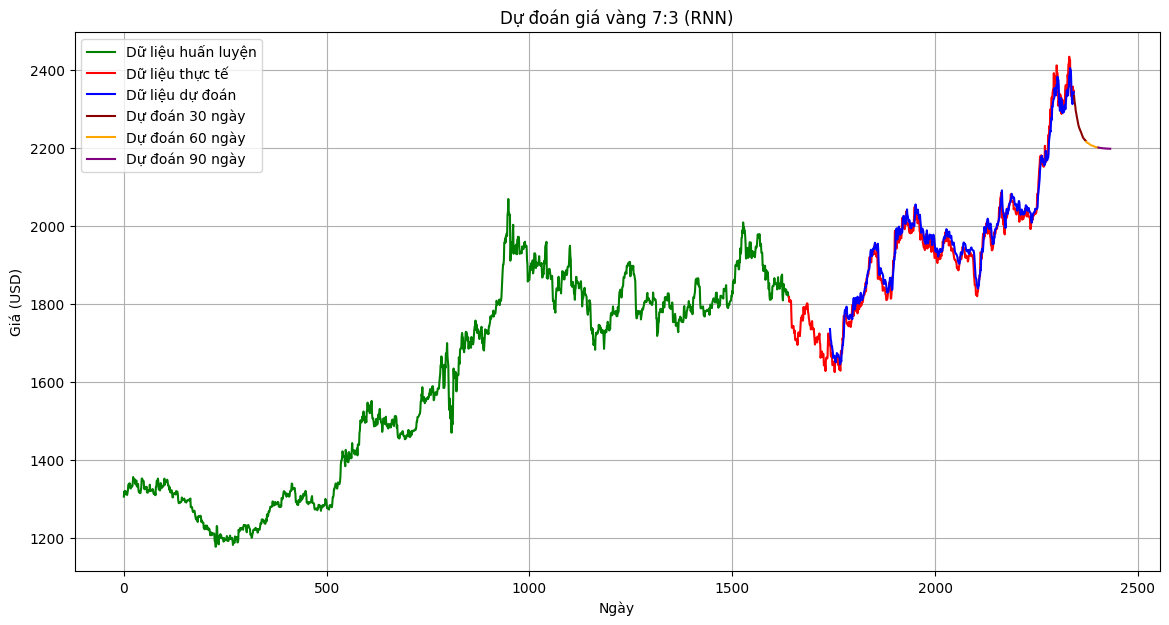

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá vàng 7:3 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()


#Chia tỉ lệ 8:2

Epoch 1/100
28/28 [==============================] - 2s 19ms/step - loss: 0.0144
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 9.2195e-04
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 6.8571e-04
Epoch 4/100
28/28 [==============================] - 1s 32ms/step - loss: 6.6018e-04
Epoch 5/100
28/28 [==============================] - 1s 33ms/step - loss: 5.9097e-04
Epoch 6/100
28/28 [==============================] - 1s 33ms/step - loss: 5.2301e-04
Epoch 7/100
28/28 [==============================] - 1s 33ms/step - loss: 5.2591e-04
Epoch 8/100
28/28 [==============================] - 1s 34ms/step - loss: 4.8843e-04
Epoch 9/100
28/28 [==============================] - 1s 29ms/step - loss: 4.5644e-04
Epoch 10/100
28/28 [==============================] - 1s 19ms/step - loss: 4.2470e-04
Epoch 11/100
28/28 [==============================] - 1s 19ms/step - loss: 4.1934e-04
Epoch 12/100
28/28 [==============================] - 1s 19ms/step 

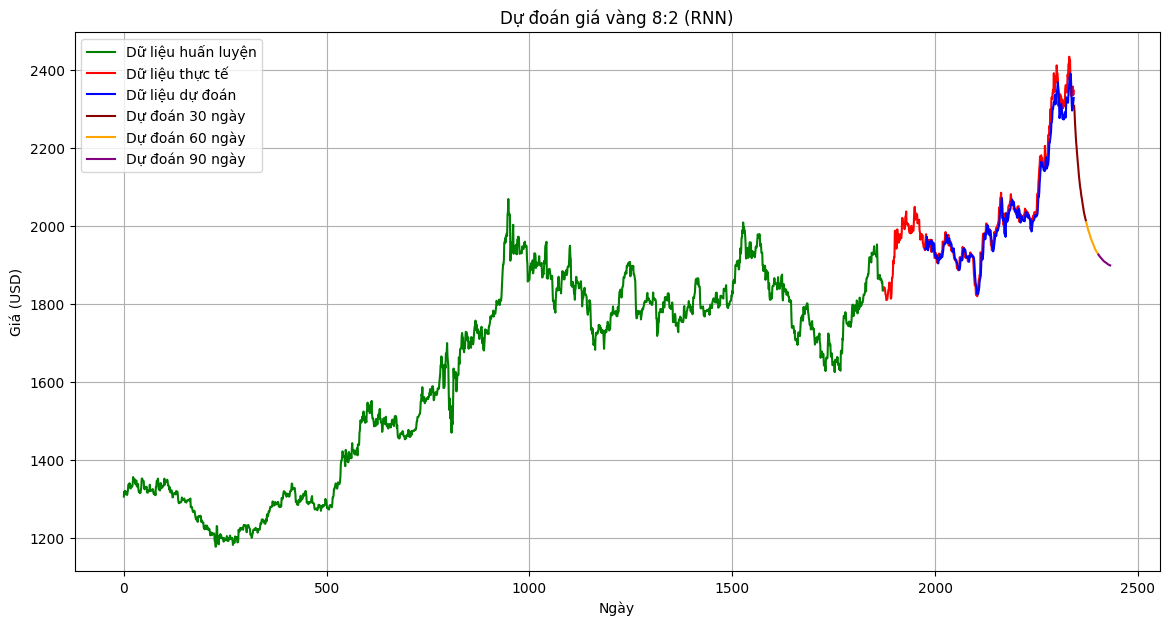

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_gold))
test_size = int(0.2 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá vàng 8:2 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()


#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_gold))
test_size = int(0.1 * len(df_gold))

train_data = df_gold[:train_size]
test_data = df_gold[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.0065
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 3.6739e-04
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 3.0344e-04
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 2.8297e-04
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 2.8691e-04
Epoch 6/100
32/32 [==============================] - 1s 27ms/step - loss: 2.7050e-04
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 2.5539e-04
Epoch 8/100
32/32 [==============================] - 1s 34ms/step - loss: 2.5271e-04
Epoch 9/100
32/32 [==============================] - 1s 31ms/step - loss: 2.3972e-04
Epoch 10/100
32/32 [==============================] - 1s 34ms/step - loss: 2.3176e-04
Epoch 11/100
32/32 [==============================] - 1s 28ms/step - loss: 2.4202e-04
Epoch 12/100
32/32 [==============================] - 1s 19ms/step 

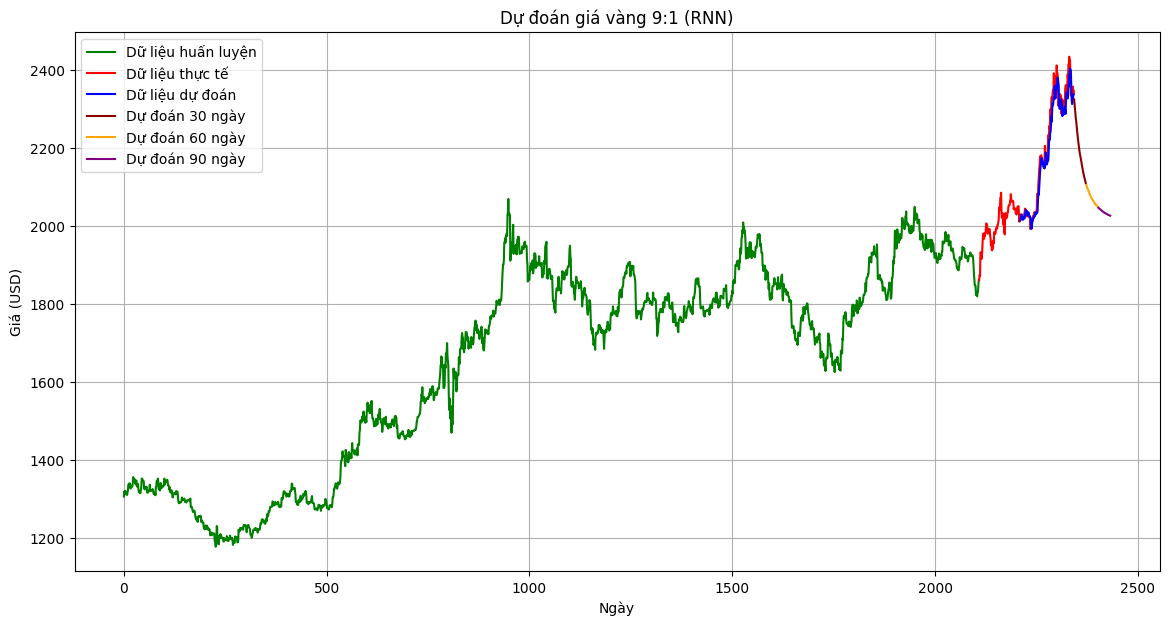

In [ ]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá vàng 9:1 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

#Dự đoán giá bạc

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_silver = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/silver_price_2018_2024.csv')
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
# df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_silver=scaler.fit_transform(np.array(df_silver['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3


In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_silver))
test_size = int(0.3 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

Epoch 1/100
25/25 [==============================] - 2s 18ms/step - loss: 0.0334
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0025
Epoch 3/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 4/100
25/25 [==============================] - 0s 20ms/step - loss: 9.9056e-04
Epoch 5/100
25/25 [==============================] - 0s 19ms/step - loss: 8.4325e-04
Epoch 6/100
25/25 [==============================] - 1s 28ms/step - loss: 7.8218e-04
Epoch 7/100
25/25 [==============================] - 1s 33ms/step - loss: 7.3900e-04
Epoch 8/100
25/25 [==============================] - 1s 32ms/step - loss: 7.2186e-04
Epoch 9/100
25/25 [==============================] - 1s 32ms/step - loss: 6.6956e-04
Epoch 10/100
25/25 [==============================] - 1s 32ms/step - loss: 6.4500e-04
Epoch 11/100
25/25 [==============================] - 1s 33ms/step - loss: 6.4799e-04
Epoch 12/100
25/25 [==============================] - 1s 35ms/step - loss: 

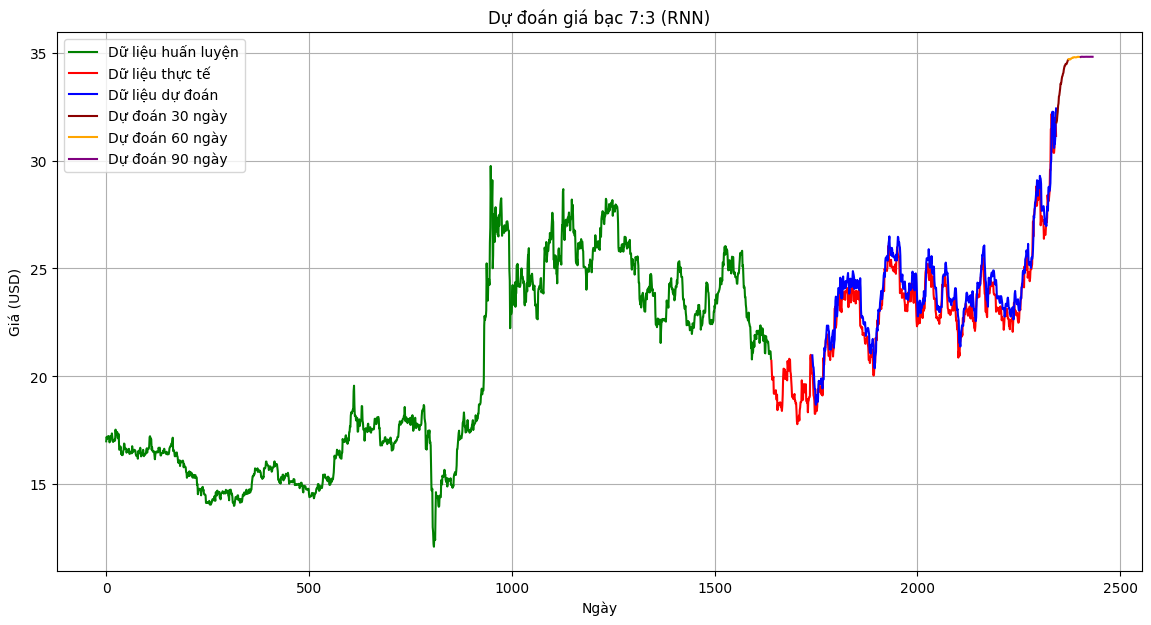

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạc 7:3 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

#Chia tỉ lệ 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_silver))
test_size = int(0.2 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
28/28 [==============================] - 2s 33ms/step - loss: 0.0869
Epoch 2/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0021
Epoch 3/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0012
Epoch 4/100
28/28 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 5/100
28/28 [==============================] - 1s 24ms/step - loss: 9.6311e-04
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 9.0568e-04
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 8.5130e-04
Epoch 8/100
28/28 [==============================] - 1s 19ms/step - loss: 8.0125e-04
Epoch 9/100
28/28 [==============================] - 1s 18ms/step - loss: 7.7477e-04
Epoch 10/100
28/28 [==============================] - 1s 19ms/step - loss: 7.7130e-04
Epoch 11/100
28/28 [==============================] - 1s 19ms/step - loss: 7.1285e-04
Epoch 12/100
28/28 [==============================] - 1s 19ms/step - loss: 7.21

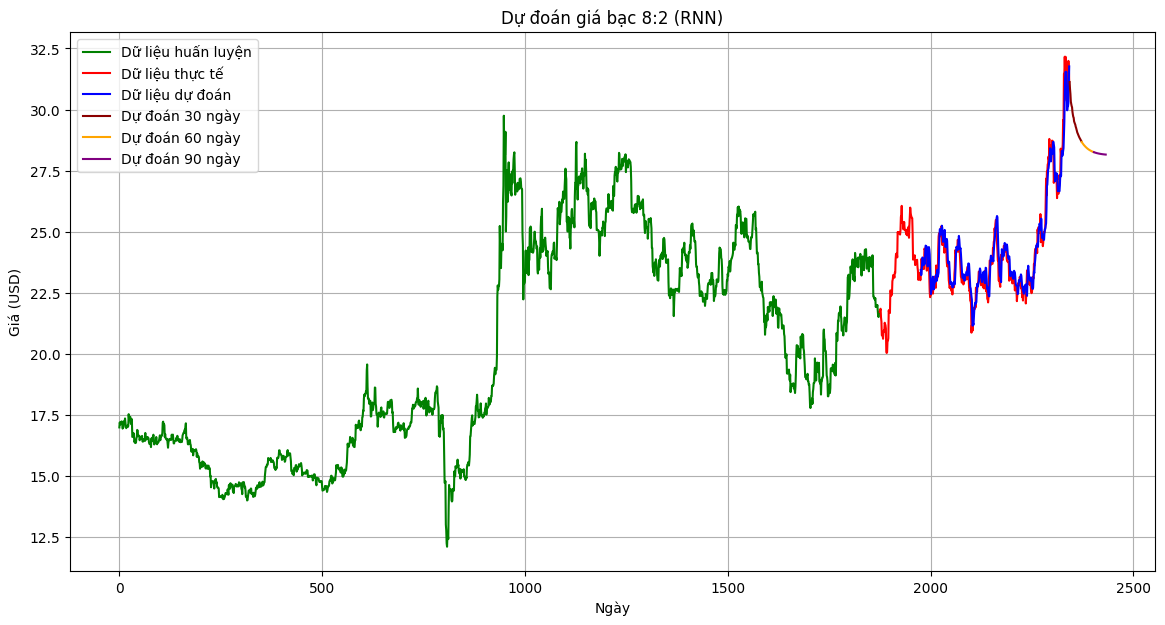

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạc 8:2 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_silver))
test_size = int(0.1 * len(df_silver))

train_data = df_silver[:train_size]
test_data = df_silver[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


Epoch 1/100
32/32 [==============================] - 2s 33ms/step - loss: 0.0282
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0018
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 5/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0011
Epoch 6/100
32/32 [==============================] - 1s 18ms/step - loss: 9.7041e-04
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 8.9306e-04
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 8.1788e-04
Epoch 9/100
32/32 [==============================] - 1s 18ms/step - loss: 7.4005e-04
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 7.0208e-04
Epoch 11/100
32/32 [==============================] - 1s 18ms/step - loss: 6.5728e-04
Epoch 12/100
32/32 [==============================] - 1s 19ms/step - loss: 6.5373e-

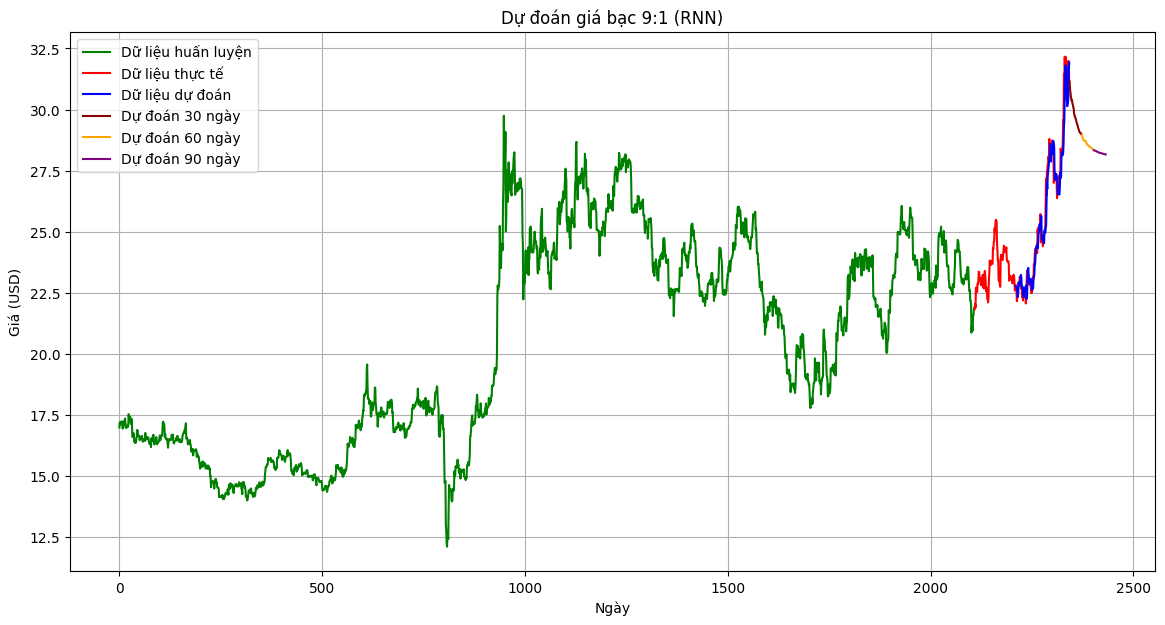

In [ ]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạc 9:1 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

##Dự đoán giá Platinum


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df_platium = pd.read_csv('/content/drive/MyDrive/DataSet/New Dataset(01 06 2024)/platium_price_2018_2024.csv')
df_platium['Date'] = pd.to_datetime(df_platium['Date'])
# df1=df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df_platium=scaler.fit_transform(np.array(df_platium['Value (USD per troy ounce)']).reshape(-1,1))

#Chia tỉ lệ 7:3

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df_platium))
test_size = int(0.3 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())



Epoch 1/100
25/25 [==============================] - 2s 29ms/step - loss: 0.0935
Epoch 2/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0063
Epoch 3/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0046
Epoch 4/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0037
Epoch 5/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0032
Epoch 6/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0030
Epoch 7/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0027
Epoch 8/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 9/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 10/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0023
Epoch 11/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 12/100
25/25 [==============================] - 0s 20ms/step - loss: 0.0021
Epoch 13/100
25/25 [=====

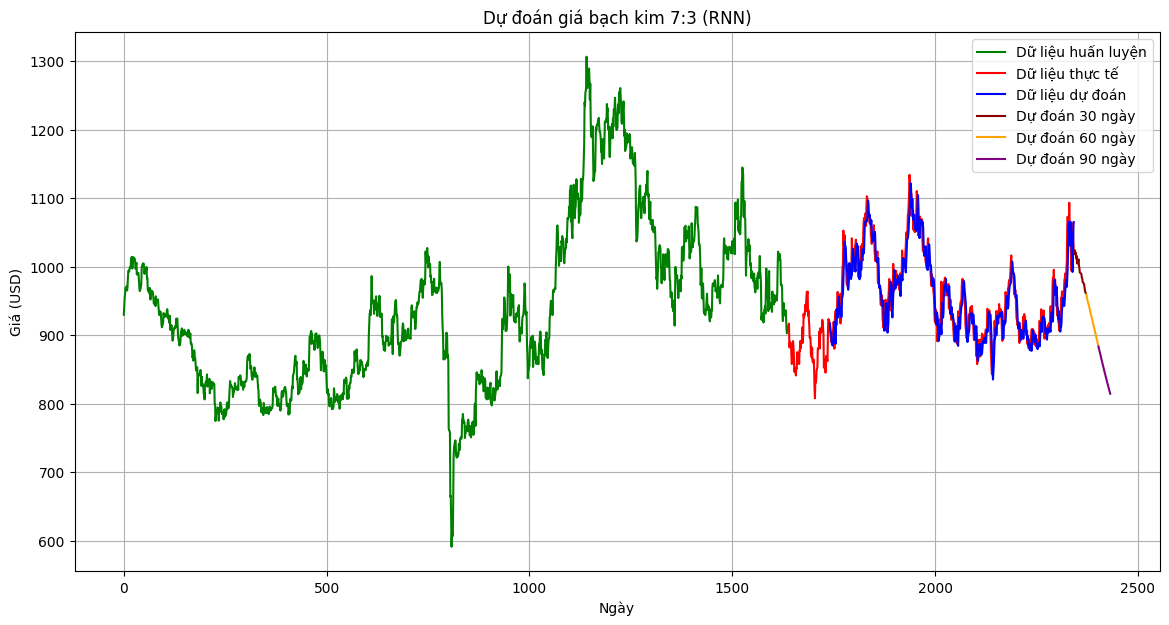

In [ ]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạch kim 7:3 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

#Chia tỉ lệ 8:2

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df_platium))
test_size = int(0.2 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())

Epoch 1/100
28/28 [==============================] - 2s 18ms/step - loss: 0.1017
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0016
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0014
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0011
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 8/100
28/28 [==============================] - 1s 18ms/step - loss: 9.7661e-04
Epoch 9/100
28/28 [==============================] - 1s 18ms/step - loss: 9.1576e-04
Epoch 10/100
28/28 [==============================] - 1s 18ms/step - loss: 8.7214e-04
Epoch 11/100
28/28 [==============================] - 1s 19ms/step - loss: 8.3040e-04
Epoch 12/100
28/28 [==============================] - 1s 18ms/step - loss: 7.9671e-04
Epoch

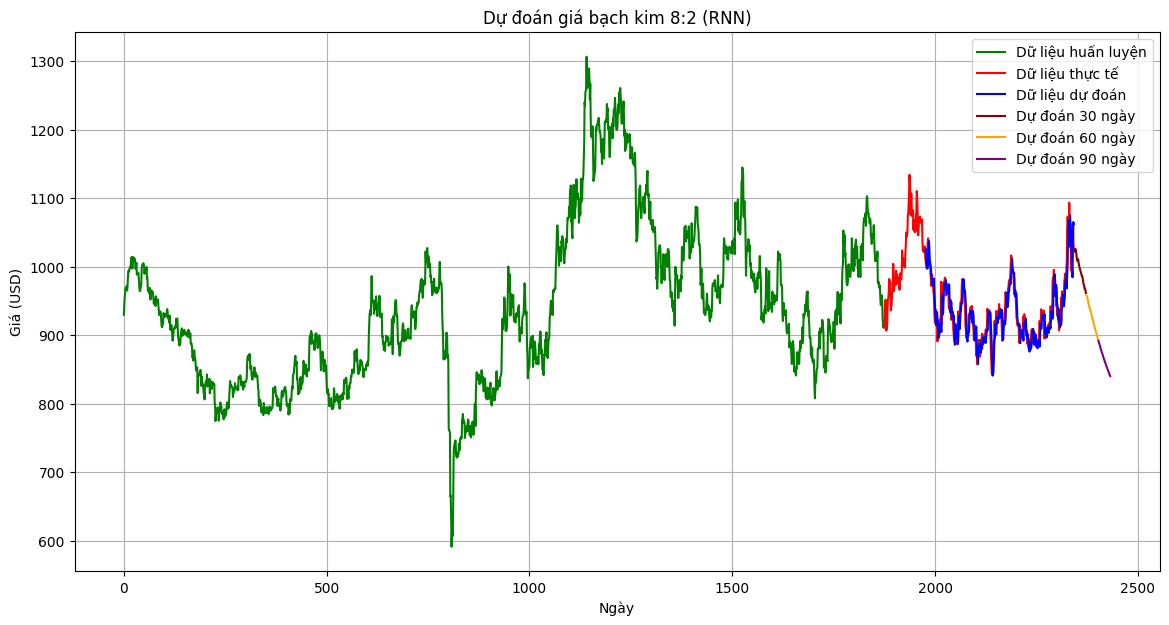

In [ ]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạch kim 8:2 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()

#Chia tỉ lệ 9:1

In [ ]:
# 4. Chia train test
train_size = int(0.9 * len(df_platium))
test_size = int(0.1 * len(df_platium))

train_data = df_platium[:train_size]
test_data = df_platium[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))

#12 Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mae = np.mean(np.abs(y_pred - ytest))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

# 13. Dự báo 30 ngày tiếp theo

x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Dự đoán 60 ngày tiếp theo
lst_output_60 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())

# Dự đoán 90 ngày tiếp theo
lst_output_90 = []
temp_input = temp_input[:]

for i in range(30):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.0074
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 9.2552e-04
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 8.7184e-04
Epoch 7/100
32/32 [==============================] - 1s 18ms/step - loss: 7.8349e-04
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 7.3665e-04
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 7.1419e-04
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 6.3496e-04
Epoch 11/100
32/32 [==============================] - 1s 24ms/step - loss: 6.6669e-04
Epoch 12/100
32/32 [==============================] - 1s 33ms/step - loss: 6.65

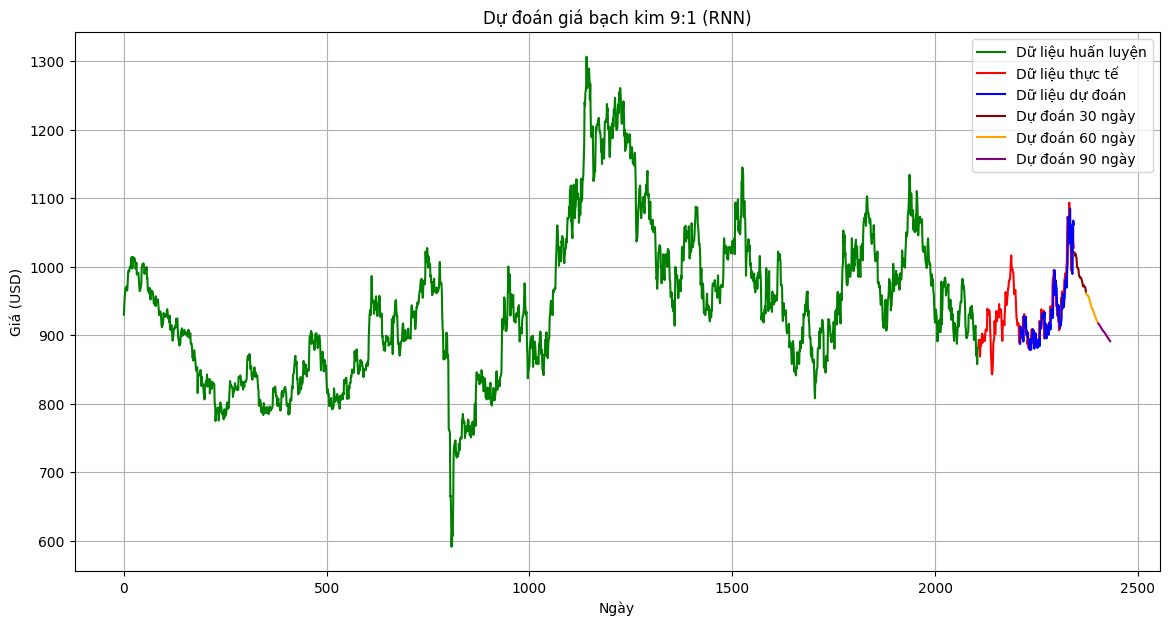

In [ ]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), color = 'green')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), color = 'red')

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), color = 'blue')

# Vẽ dữ liệu dự đoán 30 ngày tiếp theo
future_predict_index = pd.RangeIndex(start=train_size + test_size, stop=train_size + test_size + 30, step=1)
plt.plot(future_predict_index, scaler.inverse_transform(lst_output), color='darkred')

# Vẽ dữ liệu dự đoán 60 ngày tiếp theo
future_predict_index_60 = pd.RangeIndex(start=train_size + test_size + 30, stop=train_size + test_size + 60, step=1)
plt.plot(future_predict_index_60, scaler.inverse_transform(lst_output_60), color='orange')

# Vẽ dữ liệu dự đoán 90 ngày tiếp theo
future_predict_index_90 = pd.RangeIndex(start=train_size + test_size + 60, stop=train_size + test_size + 90, step=1)
plt.plot(future_predict_index_90, scaler.inverse_transform(lst_output_90), color='purple')
plt.legend(['Dữ liệu huấn luyện','Dữ liệu thực tế','Dữ liệu dự đoán', 'Dự đoán 30 ngày', 'Dự đoán 60 ngày', 'Dự đoán 90 ngày'])
plt.title('Dự đoán giá bạch kim 9:1 (RNN)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.grid(True)
plt.show()